In [1]:
!pip install --upgrade matplotlib

     |████████████████████████████████| 10.3 MB 19.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
# importing dependencies
import numpy as np
import pandas as pd
from math import sqrt
from collections import defaultdict

from pandas.tseries.holiday import USFederalHolidayCalendar
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose   
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import scale

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from datetime import datetime as dt

import warnings
import matplotlib.pyplot as plt
import pylab
warnings.filterwarnings("ignore")
import seaborn as sns
import plotly.graph_objects as go


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
calendar = pd.read_csv('/content/drive/MyDrive/calendar.csv')
sales= pd.read_csv('/content/drive/MyDrive/sales_train_evaluation.csv')
sell_prices = pd.read_csv('/content/drive/MyDrive/sell_prices.csv')

In [5]:
print("The shape of sales data:",sales.shape)
print("The shape of sell_prices data:",sell_prices.shape)
print("The shape of calender data:",calendar.shape)

The shape of sales data: (30490, 1947)
The shape of sell_prices data: (6841121, 4)
The shape of calender data: (1969, 14)


In [6]:
def checkMemUsage(df):
  """
  Helper function to check memory usage

  Input: A dataframe

  Output: Memory usage

  """
  mem_usage = df.memory_usage().sum()
  return np.round(np.round(mem_usage/(1024*1024),1))

In [7]:
print("Initial Memoery Usage: Sales {} , Calendar {} , sell_prices {}".format(checkMemUsage(sales), checkMemUsage(calendar), checkMemUsage(sell_prices)))
                                                                    

Initial Memoery Usage: Sales 453.0 , Calendar 0.0 , sell_prices 209.0


In [8]:
def performDowncast(df):

  """
  Function tpo apply downcasting 
  
  Input: A dataframe 

  Output: Dataframe with reduced memory usage
  
  
  """
  cols = df.dtypes.index.tolist()
  types = df.dtypes.values.tolist()

  for idx,dtype in enumerate(types):

      if 'int' in str(dtype):  # Downcasting for Int type variables
          if df[cols[idx]].min() > np.iinfo(np.int8).min and df[cols[idx]].max() < np.iinfo(np.int8).max:
              df[cols[idx]] = df[cols[idx]].astype(np.int8) # Downsize to int8
          elif df[cols[idx]].min() > np.iinfo(np.int16).min and df[cols[idx]].max() < np.iinfo(np.int16).max:
              df[cols[idx]] = df[cols[idx]].astype(np.int16) # Downsize to int16
          elif df[cols[idx]].min() > np.iinfo(np.int32).min and df[cols[idx]].max() < np.iinfo(np.int32).max:
              df[cols[idx]] = df[cols[idx]].astype(np.int32) # Downsize to int32
          else:
              df[cols[idx]] = df[cols[idx]].astype(np.int64) # Downsize as int64

      elif 'float' in str(dtype): # Downcasting for Float type variables
          if df[cols[idx]].min() > np.finfo(np.float16).min and df[cols[idx]].max() < np.finfo(np.float16).max:
              df[cols[idx]] = df[cols[idx]].astype(np.float16) # Downsize to float16
          elif df[cols[idx]].min() > np.finfo(np.float32).min and df[cols[idx]].max() < np.finfo(np.float32).max:
              df[cols[idx]] = df[cols[idx]].astype(np.float32) # Downsize to float32
          else:
              df[cols[idx]] = df[cols[idx]].astype(np.float64) # Downsize to float64

      elif dtype == np.object: # By default strings are treated as objects
          if cols[idx] == 'date':
              df[cols[idx]] = pd.to_datetime(df[cols[idx]], format='%Y-%m-%d')
          # else:
          #     df[cols[idx]] = df[cols[idx]].astype('category')

  return df

In [9]:
sales = performDowncast(sales)
calendar = performDowncast(calendar)
sell_prices = performDowncast(sell_prices)

print("Memory Usage after Downcasting: Sales {} , Calendar {} , sell_prices {}".format(checkMemUsage(sales), checkMemUsage(calendar), checkMemUsage(sell_prices)))

Memory Usage after Downcasting: Sales 96.0 , Calendar 0.0 , sell_prices 130.0


In [10]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


In [11]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [12]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [13]:
sales_item = sales.groupby('item_id').sum()
sales_item.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6,6,4,6,7,18,10,4,11,10,6,5,12,15.0,16,18,11.0,10.0,12.0,7.0,17.0,9,9.0,8.0,5,14.0,26.0,8.0,12.0,13,5.0,11.0,10.0,14.0,11.0,8,22,14.0,6.0,9.0,...,6.0,3,4,4,30,7.0,5.0,3.0,6.0,2,16,6,4,5.0,7.0,1.0,9,3,9.0,1.0,10,3.0,1.0,6,10,6,2.0,5.0,6.0,2.0,7,8,8,4.0,7.0,7.0,5.0,7.0,5,9.0
FOODS_1_002,4,5,7,4,3,4,1,7,2,4,4,3,1,5.0,8,5,1.0,3.0,2.0,0.0,4.0,5,4.0,2.0,2,4.0,3.0,5.0,7.0,3,3.0,4.0,7.0,7.0,3.0,4,11,0.0,1.0,1.0,...,5.0,4,5,9,4,1.0,3.0,5.0,5.0,3,3,1,9,4.0,3.0,4.0,5,7,2.0,5.0,6,3.0,2.0,4,5,3,1.0,6.0,3.0,10.0,5,8,7,2.0,6.0,5.0,0.0,6.0,6,4.0
FOODS_1_003,14,8,3,6,3,8,13,10,11,6,11,10,3,17.0,20,14,10.0,9.0,3.0,14.0,7.0,23,16.0,7.0,12,6.0,5.0,7.0,10.0,6,10.0,6.0,8.0,3.0,9.0,18,18,11.0,8.0,4.0,...,4.0,1,7,3,5,6.0,3.0,4.0,4.0,3,11,5,7,13.0,9.0,1.0,2,4,7.0,9.0,2,3.0,13.0,5,9,5,0.0,6.0,3.0,10.0,7,8,6,11.0,9.0,7.0,7.0,10.0,6,5.0
FOODS_1_004,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,15.0,33.0,67.0,118,101,132.0,119.0,156,116.0,144.0,150,173,152,123.0,100.0,95.0,112.0,115,104,107,81.0,73.0,62.0,71.0,75.0,83,93.0
FOODS_1_005,34,32,13,20,10,21,18,20,25,41,16,23,30,21.0,45,61,27.0,20.0,13.0,13.0,17.0,26,30.0,34.0,14,36.0,25.0,9.0,37.0,39,18.0,13.0,18.0,19.0,17.0,24,40,16.0,15.0,7.0,...,25.0,24,16,14,14,18.0,18.0,27.0,12.0,15,38,9,14,9.0,27.0,14.0,14,33,19.0,17.0,11,16.0,18.0,29,28,13,25.0,10.0,19.0,12.0,15,16,25,9.0,7.0,25.0,19.0,25.0,17,19.0


In [14]:
sales_store = sales.groupby('store_id').sum()
sales_store.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
store_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,2995,2710,2928,3078.0,4316,4354,2757.0,2430.0,2272.0,2009.0,3015.0,4553,3966.0,3264.0,2441,2377.0,2414.0,2701.0,3719.0,3548,2246.0,2549.0,2559.0,2568.0,2978.0,4096,4832,3138.0,2997.0,2772.0,...,3478.0,3637,3982,5437,5954,4345.0,3793.0,3722.0,3709.0,4387,5577,6113,4472,3703.0,3715.0,3618.0,4573,5898,6397.0,4794.0,4594,4234.0,3918.0,4804,6069,5212,4859.0,4104.0,3982.0,4049.0,4951,6245,6707,4568.0,3949.0,3995.0,4136.0,4433.0,5764,6289.0
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,2123,1901,2436,2584.0,3455,3563,1801.0,1797.0,1741.0,1614.0,2214.0,3080,3087.0,2601.0,1810,1851.0,1652.0,2187.0,3516.0,2692,1894.0,1958.0,1837.0,2010.0,2105.0,3199,3272,1970.0,1800.0,2064.0,...,3545.0,3441,4440,5352,5760,3830.0,3631.0,3691.0,3303.0,4457,5884,6082,3926,3525.0,3527.0,3754.0,4382,6349,6193.0,4434.0,3977,4243.0,4020.0,4492,6636,5330,3999.0,4092.0,3722.0,3751.0,4839,6507,6710,4238.0,3963.0,3789.0,4037.0,4751.0,7120,6614.0
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,4447,4544,4406,4380.0,5187,5780,3303.0,3758.0,3641.0,3099.0,3320.0,4694,4794.0,4631.0,3593,3342.0,3310.0,3575.0,4774.0,4540,3604.0,3846.0,3821.0,3757.0,3904.0,4894,5895,4274.0,4084.0,3754.0,...,5377.0,5493,5337,6936,8271,6068.0,5683.0,5235.0,5018.0,5623,7419,7721,6359,5289.0,5065.0,5015.0,5705,7057,7828.0,6776.0,6325,6204.0,5793.0,5842,7346,6743,6958.0,5960.0,5884.0,5039.0,6046,7029,7969,5891.0,5523.0,5375.0,5580.0,5542.0,7073,8144.0
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,1368,1195,1434,1312.0,1652,1933,1183.0,1511.0,1190.0,1113.0,1476.0,1543,1618.0,1501.0,1286,1371.0,1138.0,1384.0,1643.0,1711,1452.0,1429.0,1320.0,1375.0,1457.0,1595,2058,1571.0,1418.0,1361.0,...,2214.0,2498,2496,2839,3047,2809.0,2677.0,2500.0,2458.0,2628,2954,3271,2767,2495.0,2529.0,2277.0,2520,3023,3271.0,3113.0,2934,2585.0,2466.0,2500,3068,2675,3100.0,2815.0,2603.0,2659.0,2635,3256,3318,3024.0,2715.0,2519.0,2544.0,2704.0,3146,3597.0
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,1607,2149,1895,2256.0,2944,3432,1921.0,2217.0,1962.0,1821.0,1951.0,2571,2810.0,2071.0,1933,1723.0,1825.0,1886.0,2629.0,2688,1985.0,1967.0,1860.0,2052.0,1753.0,2642,3031,2272.0,1788.0,2180.0,...,2852.0,2924,3084,3724,4192,3410.0,3257.0,2901.0,2776.0,3022,3700,4033,3076,2853.0,2984.0,2664.0,3687,4052,4412.0,2859.0,3217,2839.0,3170.0,3428,4123,3196,3437.0,3020.0,3398.0,3351.0,3610,3787,5000,3708.0,3310.0,3147.0,2748.0,3664.0,4167,4624.0


In [15]:
sales_cat = sales.groupby('cat_id').sum().T
sales_cat.head()

cat_id,FOODS,HOBBIES,HOUSEHOLD
d_1,23178.0,3764.0,5689.0
d_2,22758.0,3357.0,5634.0
d_3,17174.0,2682.0,3927.0
d_4,18878.0,2669.0,3865.0
d_5,14603.0,1814.0,2729.0


In [16]:

sales_dept = sales.groupby('dept_id').sum().T
sales_dept.head()

dept_id,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
d_1,2343.0,4094.0,16741.0,3610.0,154.0,4105.0,1584.0
d_2,2216.0,4209.0,16333.0,3172.0,185.0,3858.0,1776.0
d_3,1657.0,3174.0,12343.0,2497.0,185.0,2827.0,1100.0
d_4,1508.0,3606.0,13764.0,2531.0,138.0,2732.0,1133.0
d_5,1209.0,2869.0,10525.0,1714.0,100.0,1802.0,927.0


In [17]:
sales_cat['days'] = sales_cat.index

In [18]:
sales_cat.head()

cat_id,FOODS,HOBBIES,HOUSEHOLD,days
d_1,23178.0,3764.0,5689.0,d_1
d_2,22758.0,3357.0,5634.0,d_2
d_3,17174.0,2682.0,3927.0,d_3
d_4,18878.0,2669.0,3865.0,d_4
d_5,14603.0,1814.0,2729.0,d_5


In [19]:
print(calendar.event_name_1.count(), calendar.event_type_1.count(), calendar.event_name_2.count(), calendar.event_type_2.count())

162 162 5 5


In [20]:

sales_calender = calendar.iloc[:,[0,2,3,4,5,6,8,10,11,12,13]]  # Including all special day events
print(sales_calender.shape)
sales_calender.head(10)

(1969, 11)


,date,weekday,wday,month,year,d,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,Saturday,1,1,2011,d_1,NaN,NaN,0,0,0
1,2011-01-30,Sunday,2,1,2011,d_2,NaN,NaN,0,0,0
2,2011-01-31,Monday,3,1,2011,d_3,NaN,NaN,0,0,0
3,2011-02-01,Tuesday,4,2,2011,d_4,NaN,NaN,1,1,0
4,2011-02-02,Wednesday,5,2,2011,d_5,NaN,NaN,1,0,1
5,2011-02-03,Thursday,6,2,2011,d_6,NaN,NaN,1,1,1
6,2011-02-04,Friday,7,2,2011,d_7,NaN,NaN,1,0,0
7,2011-02-05,Saturday,1,2,2011,d_8,NaN,NaN,1,1,1
8,2011-02-06,Sunday,2,2,2011,d_9,Sporting,NaN,1,1,1
9,2011-02-07,Monday,3,2,2011,d_10,NaN,NaN,1,1,0


In [21]:
print(sales_cat.shape, sales_calender.shape)
sales_cat = pd.merge(sales_calender,sales_cat,how = 'inner', left_on = 'd', right_on = 'days')
sales_cat['date'] = pd.to_datetime(sales_cat['date'])

(1941, 4) (1969, 11)


In [22]:
print(sales_cat.shape)
sales_cat.head()

(1941, 15)


,date,weekday,wday,month,year,d,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,FOODS,HOBBIES,HOUSEHOLD,days
0,2011-01-29,Saturday,1,1,2011,d_1,NaN,NaN,0,0,0,23178.0,3764.0,5689.0,d_1
1,2011-01-30,Sunday,2,1,2011,d_2,NaN,NaN,0,0,0,22758.0,3357.0,5634.0,d_2
2,2011-01-31,Monday,3,1,2011,d_3,NaN,NaN,0,0,0,17174.0,2682.0,3927.0,d_3
3,2011-02-01,Tuesday,4,2,2011,d_4,NaN,NaN,1,1,0,18878.0,2669.0,3865.0,d_4
4,2011-02-02,Wednesday,5,2,2011,d_5,NaN,NaN,1,0,1,14603.0,1814.0,2729.0,d_5


In [23]:
# sales_cat = sales_cat.set_index('date')
# sales_cat = sales_cat.reset_index()

In [24]:
sales_cat.head()

,date,weekday,wday,month,year,d,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,FOODS,HOBBIES,HOUSEHOLD,days
0,2011-01-29,Saturday,1,1,2011,d_1,NaN,NaN,0,0,0,23178.0,3764.0,5689.0,d_1
1,2011-01-30,Sunday,2,1,2011,d_2,NaN,NaN,0,0,0,22758.0,3357.0,5634.0,d_2
2,2011-01-31,Monday,3,1,2011,d_3,NaN,NaN,0,0,0,17174.0,2682.0,3927.0,d_3
3,2011-02-01,Tuesday,4,2,2011,d_4,NaN,NaN,1,1,0,18878.0,2669.0,3865.0,d_4
4,2011-02-02,Wednesday,5,2,2011,d_5,NaN,NaN,1,0,1,14603.0,1814.0,2729.0,d_5


## Not considering weather data


In [25]:
sales_cat['Day_name'] = sales_cat.date.dt.day_name()
# sales_cat['Year'] = sales_cat.date.dt.year
sales_cat['Week'] = sales_cat.date.dt.week
sales_cat['Month'] = sales_cat.date.dt.month

# introducing variable for federal holidays
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=sales_cat.date.min(), end=sales_cat.date.max()).to_pydatetime()
sales_cat['is_holiday'] = sales_cat[['date']].apply(lambda x: 1 if (x['date'] in holidays) else 0, axis = 1)

# # adding feature for weekend
# sales_cat['is_weekend'] = sales_cat[['Day_name']].apply(lambda x: 1 if (x['Day_name'] in ['Saturday', 'Sunday']) else 0, axis = 1)


# adding feature for working day or not
sales_cat['is_workingday'] = (sales_cat[['Day_name','is_holiday']]
                             .apply(lambda x: 1 if (x['Day_name'] in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] and x['is_holiday'] == 0) else 0, axis = 1))

# changing the index to date
sales_cat.set_index('date', inplace=True)
sales_cat.head()

,weekday,wday,month,year,d,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,FOODS,HOBBIES,HOUSEHOLD,days,Day_name,Week,Month,is_holiday,is_workingday
date,,,,,,,,,,,,,,,,,,,
2011-01-29,Saturday,1,1,2011,d_1,NaN,NaN,0,0,0,23178.0,3764.0,5689.0,d_1,Saturday,4,1,0,0
2011-01-30,Sunday,2,1,2011,d_2,NaN,NaN,0,0,0,22758.0,3357.0,5634.0,d_2,Sunday,4,1,0,0
2011-01-31,Monday,3,1,2011,d_3,NaN,NaN,0,0,0,17174.0,2682.0,3927.0,d_3,Monday,5,1,0,1
2011-02-01,Tuesday,4,2,2011,d_4,NaN,NaN,1,1,0,18878.0,2669.0,3865.0,d_4,Tuesday,5,2,0,1
2011-02-02,Wednesday,5,2,2011,d_5,NaN,NaN,1,0,1,14603.0,1814.0,2729.0,d_5,Wednesday,5,2,0,1


In [26]:
!pip install --upgrade matplotlib

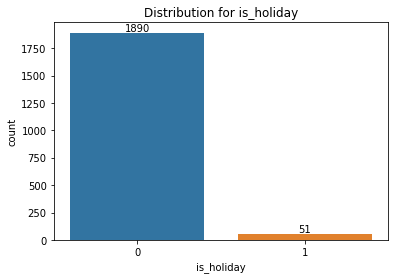

In [27]:
ax = sns.countplot(data = sales_cat, x='is_holiday')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Distribution for is_holiday')
plt.show()

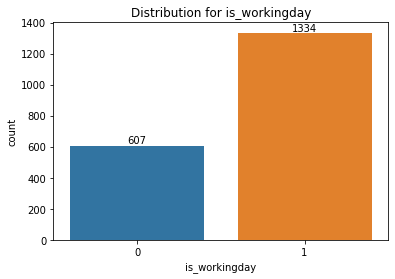

In [28]:
ax = sns.countplot(data = sales_cat, x='is_workingday')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Distribution for is_workingday')
plt.show()

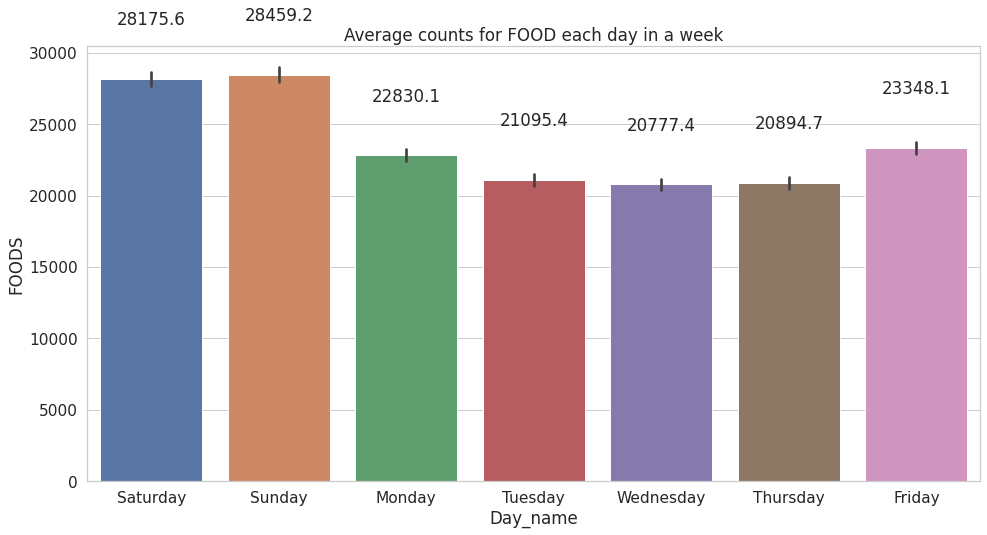

In [29]:
plt.figure(figsize=(16, 8))
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
ax = sns.barplot(data = sales_cat, x = 'Day_name', y = 'FOODS')
for container in ax.containers:
    ax.bar_label(container, padding=50)
plt.title('Average counts for FOOD each day in a week')
plt.show()

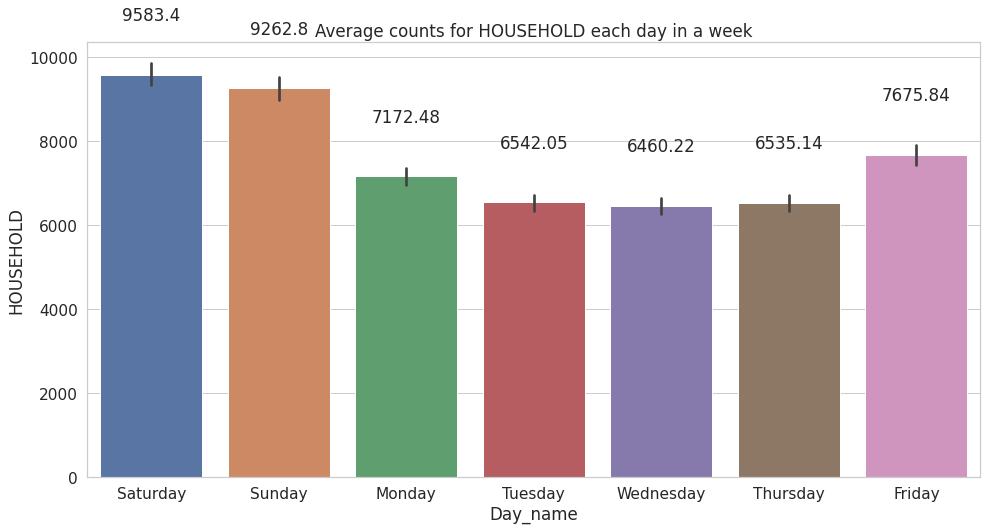

In [30]:
plt.figure(figsize=(16, 8))
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
ax = sns.barplot(data = sales_cat, x = 'Day_name', y = 'HOUSEHOLD')
for container in ax.containers:
    ax.bar_label(container, padding=50)
plt.title('Average counts for HOUSEHOLD each day in a week')
plt.show()

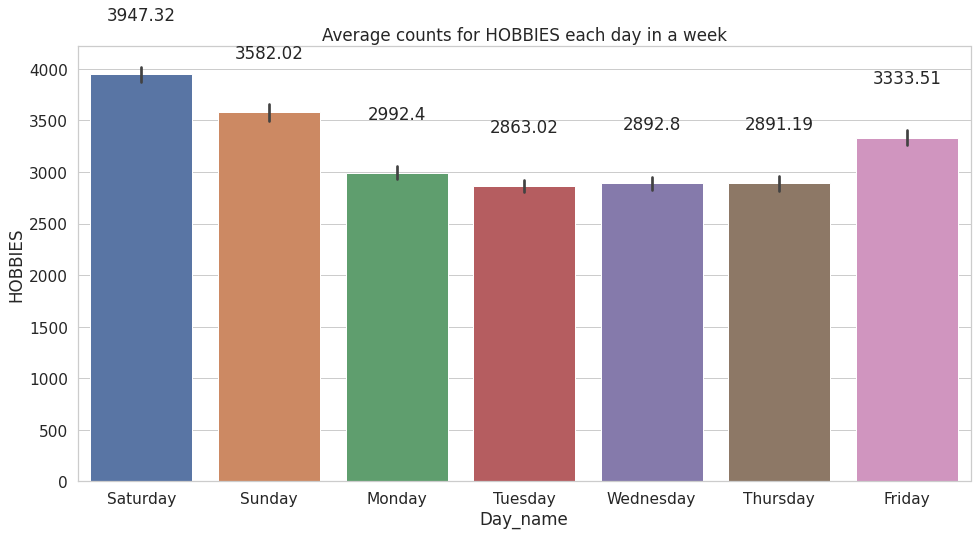

In [31]:
plt.figure(figsize=(16, 8))
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
ax = sns.barplot(data = sales_cat, x = 'Day_name', y = 'HOBBIES')
for container in ax.containers:
    ax.bar_label(container, padding=50)
plt.title('Average counts for HOBBIES each day in a week')
plt.show()

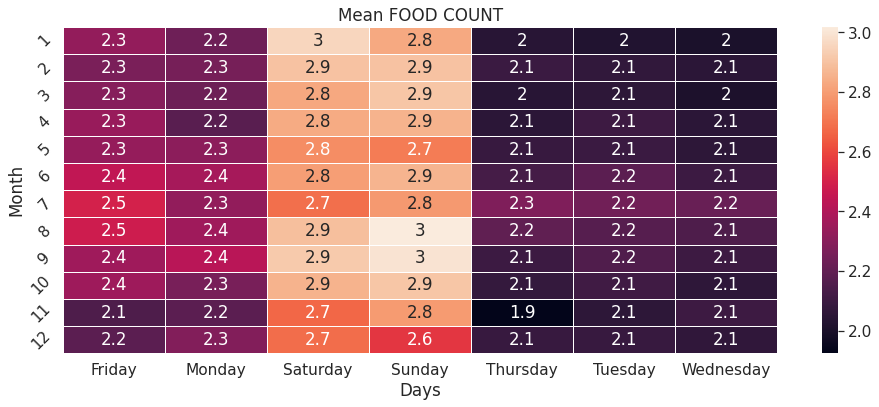

In [32]:
# observing mean order counts for days in each month
order_pattern = sales_cat.groupby(['month','Day_name']).agg({'FOODS':'mean'}).reset_index().sort_values('month', ascending= True)
order_pattern = order_pattern.pivot("month", "Day_name", "FOODS")

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(order_pattern/10**4, annot=True, linewidths=.5, ax = ax)
plt.ylabel('Month')
plt.xlabel('Days')
plt.title("Mean FOOD COUNT")
plt.yticks(rotation = 45)
plt.show()

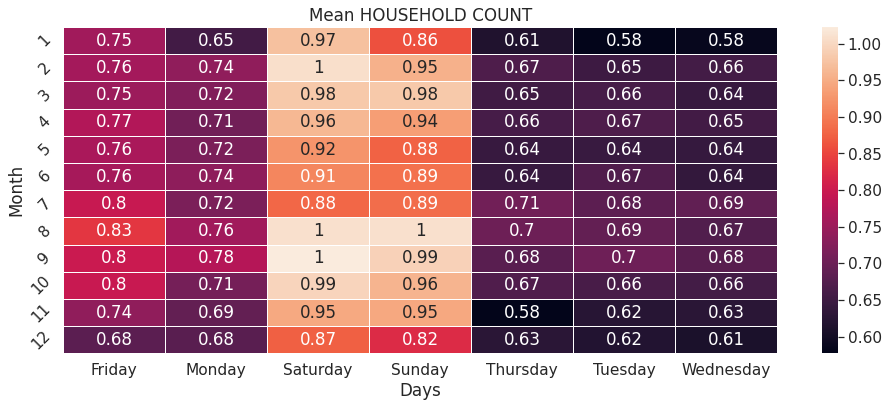

In [33]:
# observing mean order counts for days in each month
order_pattern = sales_cat.groupby(['month','Day_name']).agg({'HOUSEHOLD':'mean'}).reset_index().sort_values('month', ascending= True)
order_pattern = order_pattern.pivot("month", "Day_name", "HOUSEHOLD")

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(order_pattern/10**4, annot=True, linewidths=.5, ax = ax)
plt.ylabel('Month')
plt.xlabel('Days')
plt.title("Mean HOUSEHOLD COUNT")
plt.yticks(rotation = 45)
plt.show()

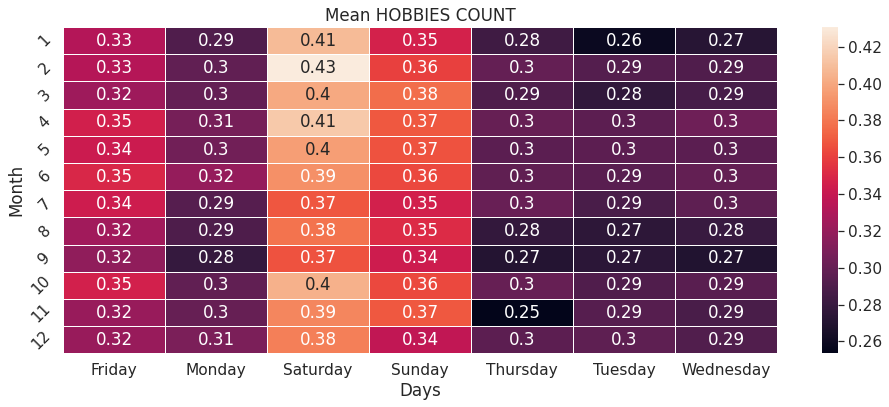

In [34]:
# observing mean order counts for days in each month
order_pattern = sales_cat.groupby(['month','Day_name']).agg({'HOBBIES':'mean'}).reset_index().sort_values('month', ascending= True)
order_pattern = order_pattern.pivot("month", "Day_name", "HOBBIES")

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(order_pattern/10**4, annot=True, linewidths=.5, ax = ax)
plt.ylabel('Month')
plt.xlabel('Days')
plt.title("Mean HOBBIES COUNT")
plt.yticks(rotation = 45)
plt.show()

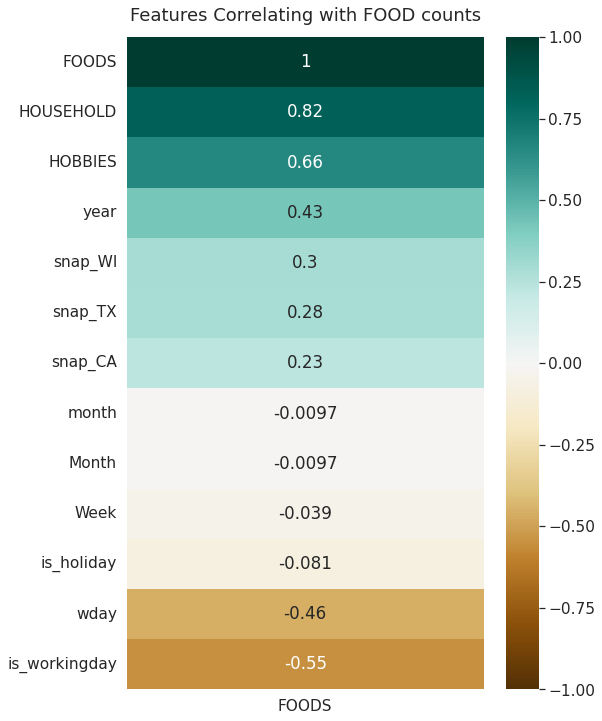

In [35]:
# observing correlation of features in preprocessed dataframe with 'order_count'
plt.figure(figsize=(8, 12))
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
heatmap = sns.heatmap(sales_cat.corr()[['FOODS']].sort_values(by='FOODS', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with FOOD counts', fontdict={'fontsize':18}, pad=16)
plt.show()

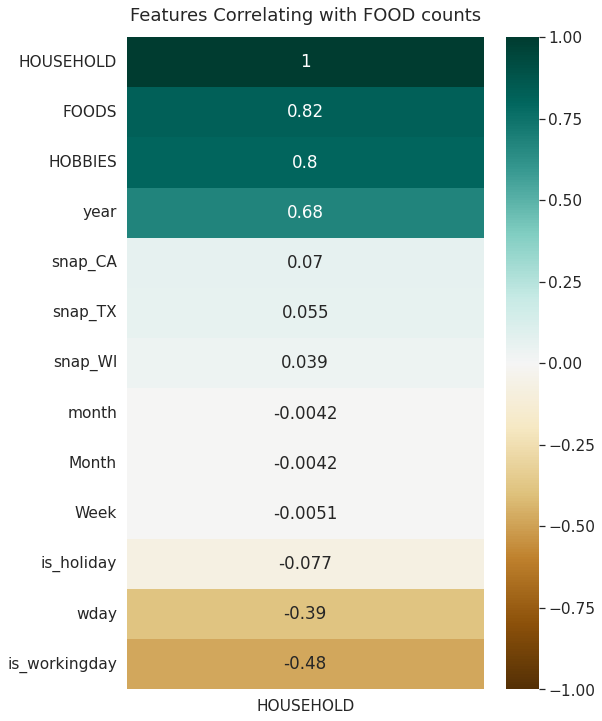

In [36]:
plt.figure(figsize=(8, 12))
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
heatmap = sns.heatmap(sales_cat.corr()[['HOUSEHOLD']].sort_values(by='HOUSEHOLD', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with FOOD counts', fontdict={'fontsize':18}, pad=16)
plt.show()

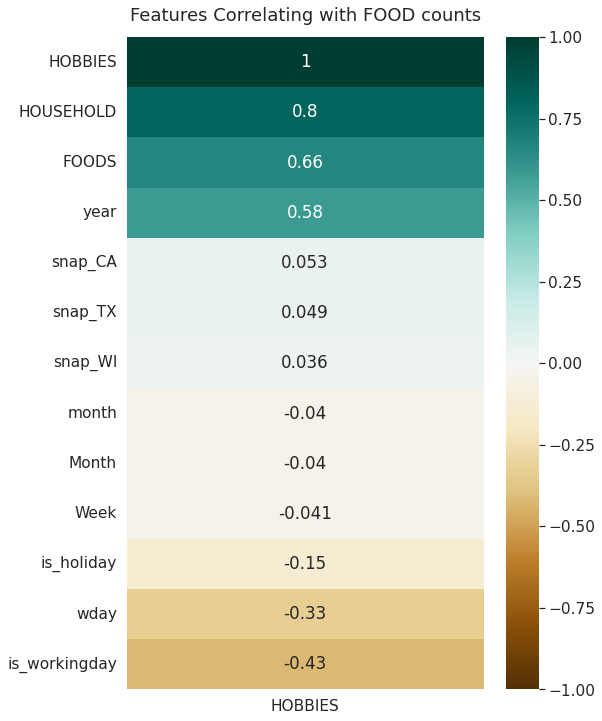

In [37]:
plt.figure(figsize=(8, 12))
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
heatmap = sns.heatmap(sales_cat.corr()[['HOBBIES']].sort_values(by='HOBBIES', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with FOOD counts', fontdict={'fontsize':18}, pad=16)
plt.show()

In [38]:
sales_cat.head()

,weekday,wday,month,year,d,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,FOODS,HOBBIES,HOUSEHOLD,days,Day_name,Week,Month,is_holiday,is_workingday
date,,,,,,,,,,,,,,,,,,,
2011-01-29,Saturday,1,1,2011,d_1,NaN,NaN,0,0,0,23178.0,3764.0,5689.0,d_1,Saturday,4,1,0,0
2011-01-30,Sunday,2,1,2011,d_2,NaN,NaN,0,0,0,22758.0,3357.0,5634.0,d_2,Sunday,4,1,0,0
2011-01-31,Monday,3,1,2011,d_3,NaN,NaN,0,0,0,17174.0,2682.0,3927.0,d_3,Monday,5,1,0,1
2011-02-01,Tuesday,4,2,2011,d_4,NaN,NaN,1,1,0,18878.0,2669.0,3865.0,d_4,Tuesday,5,2,0,1
2011-02-02,Wednesday,5,2,2011,d_5,NaN,NaN,1,0,1,14603.0,1814.0,2729.0,d_5,Wednesday,5,2,0,1


In [39]:
len(sales_cat)

1941

In [40]:
sales_cat_s = sales_cat[['month','year','event_type_1','event_type_2',	
                           'snap_CA',	'snap_TX','snap_WI','Day_name','Week','Month',
                           'is_holiday','is_workingday']]
sales_cat_s['event_type_1'] = sales_cat_s['event_type_1'].fillna('Regular')
sales_cat_s['event_type_2'] = sales_cat_s['event_type_2'].fillna('Regular')


In [43]:
sales_cat_s.head()
sales_cat_s_copy = sales_cat_s.copy()
sales_cat_s.head()

,month,year,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,Day_name,Week,Month,is_holiday,is_workingday
date,,,,,,,,,,,,
2011-01-29,1,2011,Regular,Regular,0,0,0,Saturday,4,1,0,0
2011-01-30,1,2011,Regular,Regular,0,0,0,Sunday,4,1,0,0
2011-01-31,1,2011,Regular,Regular,0,0,0,Monday,5,1,0,1
2011-02-01,2,2011,Regular,Regular,1,1,0,Tuesday,5,2,0,1
2011-02-02,2,2011,Regular,Regular,1,0,1,Wednesday,5,2,0,1


In [44]:
start_date = '2016-04-25'

# RANDOM FOREST

In [47]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

def model_fit_rf(df,category,start_date):
  print('prediction for :',category)
  df_category = df
  df_category[category] = sales_cat[category] 
  df_category_dummies = pd.get_dummies(df_category, columns=['Day_name','event_type_1','event_type_2']) 
  y = df_category_dummies[category]
  x = df_category_dummies.drop(category,axis = 1)
  print(x.columns)
  start_forecast_date = start_date
  x_train = x[:start_forecast_date]
  x_test = x[start_forecast_date::]
  y_train = y.loc[:start_forecast_date]
  y_test = y.loc[start_forecast_date::]
  n_estimators = list(range(70, 300, 20))
  max_features = ['auto', 'sqrt']
  max_depth = list(range(1,6))
  # Create the random grid
  random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth':max_depth}

  # First create the base model to tune
  rf = RandomForestRegressor()

  # Creating a time series split as discussed in the Introduction
  tscv = TimeSeriesSplit(n_splits=5)
  # Random search of parameters
  rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, 
                                cv = tscv, scoring = 'r2', verbose=2, n_jobs = -1)

  # Fit the random search model
  rf_random.fit(x_train, y_train)

  print(rf_random.best_params_)
  print("train score",rf_random.score(x_train, y_train))
  print("test score",rf_random.score(x_test, y_test))
  features = pd.Series(rf_random.best_estimator_.feature_importances_, index=x_train.columns)
  print('Top 10 features for prediction:')
  print(features.sort_values(ascending=False)[0:10])
  y_test_pred = pd.Series(rf_random.best_estimator_.predict(x_test).astype('int32'),index=y_test.index)
# Predict over the train period and combine with test period in order to calculate residuals
  y_train_pred = pd.Series(rf_random.best_estimator_.predict(x_train).astype('int32'),index=y_train.index)

  total_pred = pd.concat([y_train_pred, y_test_pred], axis=0)

  # Plot both the actual data and forecasted data
  fig = plt.figure(figsize=(18,18))
  ax1 = fig.add_subplot(311)
  ax1.set_title('Actual number of order_counts vs Predicted number of order_counts')
  plt.plot(y_test, 'b-', label='actual')
  plt.plot(y_test_pred, 'r--', label='predicted')
  plt.xticks(rotation = 45)
  ax1.set_xlabel('Dates')
  ax1.set_ylabel('order_counts')
  ax1.legend(loc='best')
  print(' ')
  print('Random Forest Regressor Model - from {}'.format(start_date))
  print('='*50)
  print('R2 score on test data: {}'.format(r2_score(y_test, y_test_pred)))

  # Calculate the absolute error in the prediction vs actual number of trips
  abs_error = (y_test - y_test_pred).abs()

  # Calculate the percentage error = absolute_error / actual trips
  percent_error = (abs_error / y_test)

  rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

  print(' ')
  print('Average absolute error: {}'.format(abs_error.mean()))
  print('RMSE: {}'.format(rmse))
  print('Average percentage error: {}'.format(percent_error.mean()))

## FOODS

prediction for : FOODS
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.5min finished


{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 190}
train score 0.8226600137004291
test score -0.04061390687250599
Top 10 features for prediction:
is_workingday            0.387886
year                     0.290169
snap_WI                  0.082609
Week                     0.050375
event_type_1_National    0.045407
snap_TX                  0.026044
Month                    0.023442
month                    0.022600
is_holiday               0.022488
Day_name_Friday          0.019759
dtype: float64
 
Random Forest Regressor Model - from 2016-04-25
R2 score on test data: -0.04083775203344797
 
Average absolute error: 4297.142857142857
RMSE: 4628.87710851285
Average percentage error: 0.14395778048008614


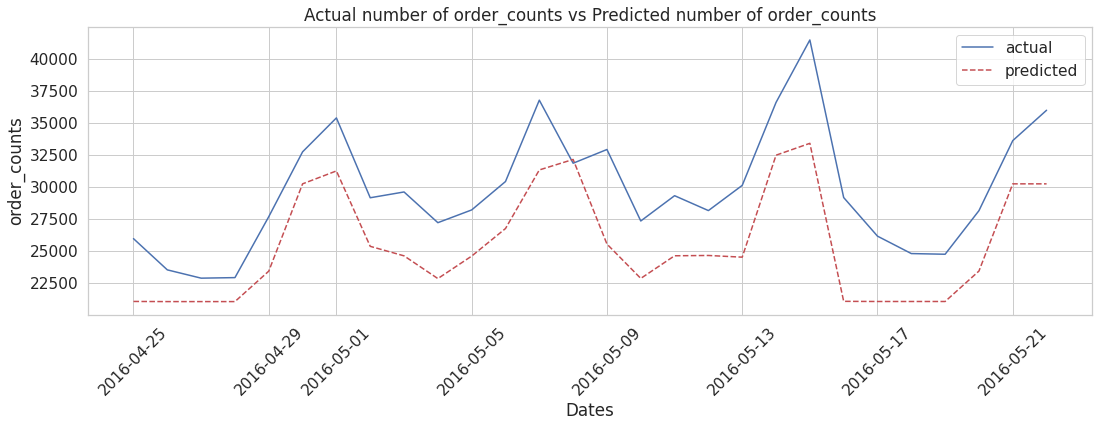

In [46]:
model_fit_rf(sales_cat_s,'FOODS',start_date)

## HOUSEHOLD

prediction for : HOUSEHOLD
Index(['month', 'year', 'snap_CA', 'snap_TX', 'snap_WI', 'Week', 'Month',
       'is_holiday', 'is_workingday', 'Day_name_Friday', 'Day_name_Monday',
       'Day_name_Saturday', 'Day_name_Sunday', 'Day_name_Thursday',
       'Day_name_Tuesday', 'Day_name_Wednesday', 'event_type_1_Cultural',
       'event_type_1_National', 'event_type_1_Regular',
       'event_type_1_Religious', 'event_type_1_Sporting',
       'event_type_2_Cultural', 'event_type_2_Regular',
       'event_type_2_Religious'],
      dtype='object')
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.5min finished


{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 110}
train score 0.8936626124183973
test score 0.7138611925205433
Top 10 features for prediction:
year                     0.546698
is_workingday            0.270061
event_type_1_National    0.038393
month                    0.029389
Month                    0.029363
Week                     0.027657
Day_name_Friday          0.026587
is_holiday               0.011501
Day_name_Tuesday         0.005681
Day_name_Thursday        0.004897
dtype: float64
 
Random Forest Regressor Model - from 2016-04-25
R2 score on test data: 0.7136588556785628
 
Average absolute error: 755.5
RMSE: 921.4109134520664
Average percentage error: 0.07171131337708392


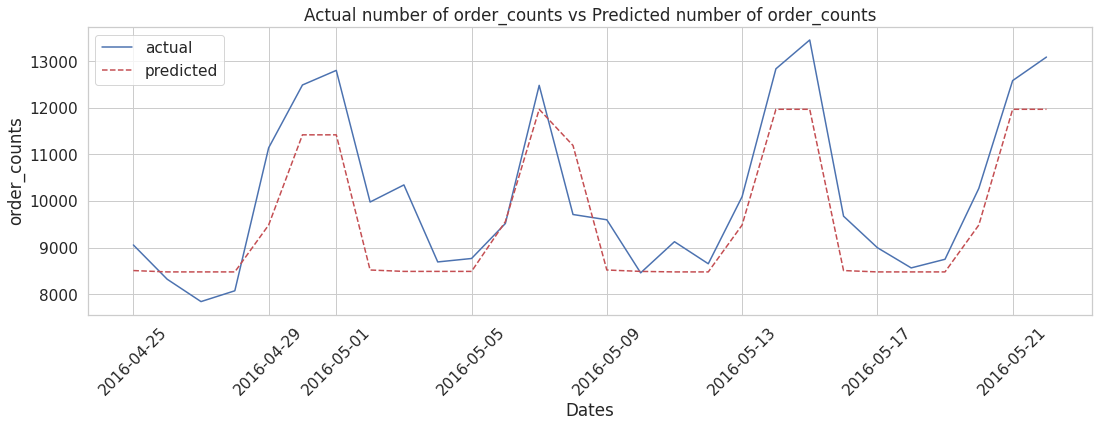

In [48]:
model_fit_rf(sales_cat_s_copy,'HOUSEHOLD',start_date)

In [50]:
sales_cat_s = sales_cat_s.drop('FOODS',axis =1)
sales_cat_s.head()

,month,year,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,Day_name,Week,Month,is_holiday,is_workingday
date,,,,,,,,,,,,
2011-01-29,1,2011,Regular,Regular,0,0,0,Saturday,4,1,0,0
2011-01-30,1,2011,Regular,Regular,0,0,0,Sunday,4,1,0,0
2011-01-31,1,2011,Regular,Regular,0,0,0,Monday,5,1,0,1
2011-02-01,2,2011,Regular,Regular,1,1,0,Tuesday,5,2,0,1
2011-02-02,2,2011,Regular,Regular,1,0,1,Wednesday,5,2,0,1


## HOBBIES

prediction for : HOBBIES
Index(['month', 'year', 'snap_CA', 'snap_TX', 'snap_WI', 'Week', 'Month',
       'is_holiday', 'is_workingday', 'Day_name_Friday', 'Day_name_Monday',
       'Day_name_Saturday', 'Day_name_Sunday', 'Day_name_Thursday',
       'Day_name_Tuesday', 'Day_name_Wednesday', 'event_type_1_Cultural',
       'event_type_1_National', 'event_type_1_Regular',
       'event_type_1_Religious', 'event_type_1_Sporting',
       'event_type_2_Cultural', 'event_type_2_Regular',
       'event_type_2_Religious'],
      dtype='object')
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.5min finished


{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 150}
train score 0.7902385131279978
test score 0.46770743221078814
Top 10 features for prediction:
year                     0.496662
is_workingday            0.166929
Day_name_Saturday        0.093093
event_type_1_National    0.065452
Day_name_Friday          0.052446
Week                     0.046828
Day_name_Sunday          0.032036
month                    0.015762
Month                    0.015210
is_holiday               0.004216
dtype: float64
 
Random Forest Regressor Model - from 2016-04-25
R2 score on test data: 0.46629034620152254
 
Average absolute error: 348.60714285714283
RMSE: 427.25991587590534
Average percentage error: 0.07982064785788319


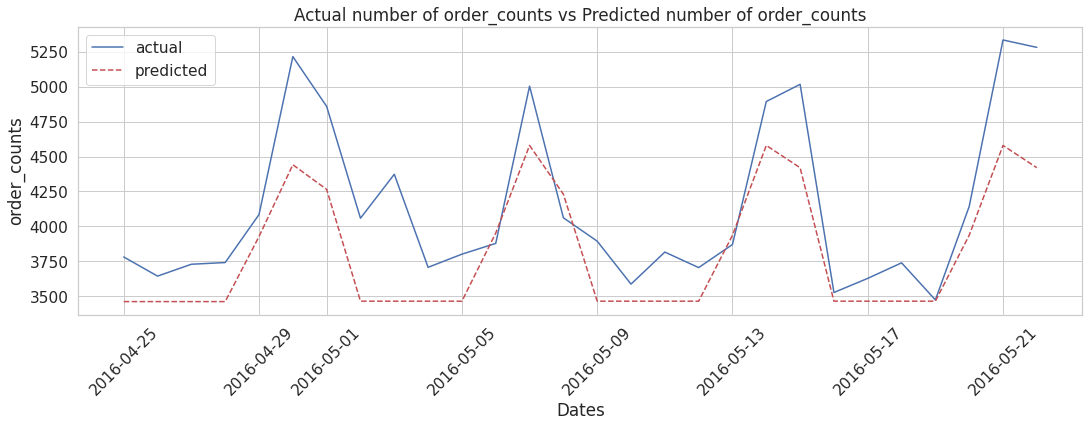

In [51]:
model_fit_rf(sales_cat_s,'HOBBIES',start_date)

## XGBOOST